### Initial Implementation

##### 1. Imports

In [7]:
import numpy as np
import pandas as pd
from datasets import load_dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, accuracy_score

##### 2. Load Dataset

In [73]:
data = load_dataset("shainar/BEAD", "Full_Annotations", split="full")
print(data)

Dataset({
    features: ['text', 'dimension', 'biased_words', 'aspect', 'label', 'sentiment', 'toxic', 'identity_mention'],
    num_rows: 3674927
})


In [9]:
df = data.to_pandas()
print(df.head())

                                                text             dimension  \
0  Where will this leave the kids??? That my frie...  Ageism and sentiment   
1   I had a feeling of impending doom &amp; then ...  Ageism and sentiment   
2                                 I no feel good ..   Ageism and sentiment   
3  Back in Hotlanta for a about a week, then off ...  Ageism and sentiment   
4  Kids toys &amp; stamping stuff cleaned up... N...  Ageism and sentiment   

            biased_words          aspect            label sentiment  toxic  \
0                     []     Transphobia  Slightly Biased  Negative    0.0   
1  ['impending', 'doom']  Climate change    Highly Biased  Negative    1.0   
2                     []    Body-shaming          Neutral  Positive    0.0   
3                     []       Lifestyle  Slightly Biased  Negative    0.0   
4                     []           Hobby          Neutral   Neutral    1.0   

  identity_mention  
0               NO  
1               NO  

In [10]:
df = df.sample(n=300000, random_state=42, replace=True)
print(df.shape)

(300000, 8)


##### 3. Text Pre-processing

In [11]:
print(df.isnull().sum())

text                    0
dimension               0
biased_words            0
aspect              14474
label                   0
sentiment               0
toxic                   0
identity_mention        0
dtype: int64


In [12]:
df = df.dropna(subset=['text'])

In [13]:
df = df.drop_duplicates(subset='text')

In [14]:
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 1
Max text snippet length: 37903
Avg text snippet length: 211.623966726959


In [15]:
text_len = df['text'].str.len()
ind = text_len.idxmin()
row = df.loc[ind]
print(row)

text                       🙄
dimension           toxicity
biased_words              []
aspect                  None
label                Neutral
sentiment            Neutral
toxic                    0.0
identity_mention          NO
Name: 3055173, dtype: object


In [16]:
min_len = 5
ind_drop = df[df['text'].str.len() < min_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 60 rows.


In [17]:
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 5
Max text snippet length: 37903
Avg text snippet length: 211.66738430660357


In [18]:
import re

text = df['text']

text = text.apply(lambda x: x.lower())
def edit(text):
	text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)
	text = re.sub(r'https?://\S+|www\.\S+', '', text)
	text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text
text = text.apply(edit)

df['text'] = text

In [19]:
min_len = 5
ind_drop = df[df['text'].str.len() < min_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 222 rows.


In [20]:
df['text'] = df['text'].astype(str)
df['text'] = df['text'].fillna('')

##### 4. Dataset Characteristics

In [21]:
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 5
Max text snippet length: 32191
Avg text snippet length: 204.14514923946774


In [22]:
print(f"{len(df)} rows.")

287759 rows.


In [23]:
print(df['label'].value_counts())

label
Neutral            147791
Slightly Biased     81252
Highly Biased       58716
Name: count, dtype: int64


In [24]:
print(df['sentiment'].value_counts())

sentiment
Positive    131584
Negative     95935
Neutral      60240
Name: count, dtype: int64


In [25]:
print(df['toxic'].value_counts())

toxic
0.0    192042
1.0     95717
Name: count, dtype: int64


##### 5. One-Hot Encoding

In [26]:
y = pd.DataFrame(data)
target_columns = ['label', 'sentiment', 'toxic']

encoders = {}
for col in target_columns:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  encoders[col] = le

print(df.head())

                                                      text  \
2219110  my bestie changed her username to leeshpaugaso...   
2768307  err, your. must be time for bed. im lucky enou...   
2229084             pam16gem yup yup yup bitchy tinkerbell   
3511566  and, gee, sometimes even more than a reasonabl...   
2356330  this german story is bogus. if the song was or...   

                    dimension biased_words             aspect  label  \
2219110  Ageism and sentiment           []        Transphobia      1   
2768307              toxicity           []               None      1   
2229084  Ageism and sentiment   ['bitchy']        Personality      0   
3511566              toxicity           []       Professional      1   
2356330              toxicity           []  Nation stereotype      2   

         sentiment  toxic identity_mention  
2219110          2      0               NO  
2768307          2      1               NO  
2229084          0      1               NO  
3511566       

In [27]:
print(encoders['toxic'].classes_)

[0. 1.]


##### 6. Tokenisation & Padding

In [28]:
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

In [29]:
y = df[['label', 'sentiment', 'toxic']]
print(y)

         label  sentiment  toxic
2219110      1          2      0
2768307      1          2      1
2229084      0          0      1
3511566      1          2      0
2356330      2          0      0
...        ...        ...    ...
522136       1          2      1
2461242      2          0      0
774320       1          1      0
1482739      1          1      0
2184712      1          2      1

[287759 rows x 3 columns]


##### 7. Train-Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

##### 8. Model Architecture

In [31]:
print("X_train:", X_train.shape)
print("y_train[label]:", y_train["label"].shape)
print("y_train[sentiment]:", y_train["sentiment"].shape)
print("y_train[toxic]:", y_train["toxic"].shape)

print("X_valid:", X_valid.shape)
print("y_valid[label]:", y_valid["label"].shape)
print("y_valid[sentiment]:", y_valid["sentiment"].shape)
print("y_valid[toxic]:", y_valid["toxic"].shape)

y_train_label = y_train["label"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_valid_label = y_valid["label"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

X_train: (230207, 100)
y_train[label]: (230207,)
y_train[sentiment]: (230207,)
y_train[toxic]: (230207,)
X_valid: (28776, 100)
y_valid[label]: (28776,)
y_valid[sentiment]: (28776,)
y_valid[toxic]: (28776,)


In [32]:
embedding_dim = 128

# input layer
input_layer = Input(shape=(X_train.shape[1],))

# hidden layers
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, input_length=MAX_LEN)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# output layers
output_label = Dense(len(encoders['label'].classes_), activation='softmax', name="output_l")(x)
output_sentiment = Dense(len(encoders['sentiment'].classes_), activation='softmax', name="output_s")(x)
output_toxic = Dense(len(encoders['toxic'].classes_), activation='softmax', name="output_t")(x)

model = Model(inputs=input_layer, outputs=[output_label, output_sentiment, output_toxic])

# model.build(input_shape=(None, MAX_LEN))
model.compile(
    optimizer='adam',
    loss={
        "output_l": "sparse_categorical_crossentropy",
        "output_s": "sparse_categorical_crossentropy",
        "output_t": "sparse_categorical_crossentropy"
    },
    metrics={
        "output_l": "accuracy",
        "output_s": "accuracy",
        "output_t": "accuracy"
    }
  )

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_l (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,387,848 (5.29 MB)

 Trainable params: 1,387,720 (5.29 MB)

 Non-trainable params: 128 (512.00 B)

##### 9. Model Training

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train,
    {
        "output_l": y_train_label,
        "output_s": y_train_sentiment,
        "output_t": y_train_toxic
    },
    validation_data=(
        X_valid,
        {
            "output_l": y_valid_label,
            "output_s": y_valid_sentiment,
            "output_t": y_valid_toxic
        }
    ),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
7194/7194 ━━━━━━━━━━━━━━━━━━━━ 126s 16ms/step - loss: 1.9642 - output_l_accuracy: 0.6722 - output_l_loss: 0.7283 - output_s_accuracy: 0.7138 - output_s_loss: 0.6685 - output_t_accuracy: 0.7128 - output_t_loss: 0.5674 - val_loss: 1.2707 - val_output_l_accuracy: 0.8085 - val_output_l_loss: 0.4741 - val_output_s_accuracy: 0.8739 - val_output_s_loss: 0.3706 - val_output_t_accuracy: 0.8079 - val_output_t_loss: 0.4259
Epoch 2/10
7194/7194 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - loss: 1.3106 - output_l_accuracy: 0.8067 - output_l_loss: 0.4943 - output_s_accuracy: 0.8762 - output_s_loss: 0.3852 - output_t_accuracy: 0.8103 - output_t_loss: 0.4310 - val_loss: 1.1682 - val_output_l_accuracy: 0.8314 - val_output_l_loss: 0.4312 - val_output_s_accuracy: 0.8879 - val_output_s_loss: 0.3385 - val_output_t_accuracy: 0.8237 - val_output_t_loss: 0.3984
Epoch 3/10
7194/7194 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - loss: 1.1919 - output_l_accuracy: 0.8336 - output_l_loss: 0.4459 - output_s_accuracy: 0

##### 10. Model Evaluation

In [34]:
y_pred_probs = model.predict(X_test)

y_pred_label = np.argmax(y_pred_probs[0], axis=1)
y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

y_true_label = y_test["label"].to_numpy()
y_true_sentiment = y_test["sentiment"].to_numpy()
y_true_toxic = y_test["toxic"]

print("=== Label Task ===")
print("Accuracy:", accuracy_score(y_true_label, y_pred_label))
print(classification_report(y_true_label, y_pred_label, target_names=encoders["label"].classes_))

print("\n=== Sentiment Task ===")
print("Accuracy:", accuracy_score(y_true_sentiment, y_pred_sentiment))
print(classification_report(y_true_sentiment, y_pred_sentiment, target_names=encoders["sentiment"].classes_))

print("\n=== Toxic Task ===")
print("Accuracy:", accuracy_score(y_true_toxic, y_pred_toxic))
# print(classification_report(y_true_toxic, y_pred_toxic, target_names=encoders["toxic"].classes_))
print("Toxic Classification Report:\n",
      classification_report(
          y_true_toxic,
          y_pred_toxic,
          target_names=[str(cls) for cls in encoders["toxic"].classes_]   # ensure strings
      ))

900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
=== Label Task ===
Accuracy: 0.8335418404225744
                 precision    recall  f1-score   support

  Highly Biased       0.79      0.80      0.80      5872
        Neutral       0.90      0.92      0.91     14779
Slightly Biased       0.73      0.70      0.72      8125

       accuracy                           0.83     28776
      macro avg       0.81      0.81      0.81     28776
   weighted avg       0.83      0.83      0.83     28776


=== Sentiment Task ===
Accuracy: 0.8912635529608006
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      9595
     Neutral       0.94      0.86      0.90      6024
    Positive       0.90      0.91      0.90     13157

    accuracy                           0.89     28776
   macro avg       0.90      0.88      0.89     28776
weighted avg       0.89      0.89      0.89     28776


=== Toxic Task ===
Accuracy: 0.8255143174867946
Toxic Classification Repor

#### Neutrosophic Integration for Bias Label

In [65]:
import numpy as np
from scipy.stats import entropy

def softmax_to_neutrosophic(pred_probs, uncertainty_scale=1.0):
    results = {}

    ent = entropy(pred_probs, base=2)
    max_ent = np.log2(len(pred_probs))  # max possible entropy for normalization
    I_base = ent / max_ent  # normalized [0,1]
    I = min(1.0, I_base * uncertainty_scale)

    for i, p in enumerate(pred_probs):
        T = p
        F = max(0.0, 1 - T - I)
        results[i] = (T, I, F)

    return results

# softmax_out = np.array([0.1, 0.7, 0.2])
# neutrosophic_repr = softmax_to_neutrosophic(softmax_out)
# for cls in neutrosophic_repr:
#     print(f"Class {cls}: T={neutrosophic_repr[cls][0]}, I={neutrosophic_repr[cls][1]}, F={neutrosophic_repr[cls][2]}")

In [69]:
def neutrosophic_evaluation(model, X_test, y_test, threshold=0.3):
    probs = y_pred_probs[0]
    y_true = y_test["label"].to_numpy() if hasattr(y_test["label"], "to_numpy") else y_test["label"]

    confident_correct = 0
    confident_wrong   = 0
    indeterminate_correct = 0
    indeterminate_wrong   = 0

    for i in range(len(y_true)):
        pred_probs = probs[i]
        max_prob = np.max(pred_probs)
        pred_class = np.argmax(pred_probs)

        if max_prob >= threshold:
            # confident case
            if pred_class == y_true[i]:
                confident_correct += 1
            else:
                confident_wrong += 1
        else:
            # indeterminate case
            if pred_class == y_true[i]:
                indeterminate_correct += 1
            else:
                indeterminate_wrong += 1

    total = len(y_true)
    metrics = {
        "Confident Accuracy": confident_correct / total,
        "Confident Wrong": confident_wrong / total,
        "Indeterminate Correct": indeterminate_correct / total,
        "Indeterminate Wrong": indeterminate_wrong / total,
        "Total Accuracy": (confident_correct + indeterminate_correct) / total
    }
    return metrics

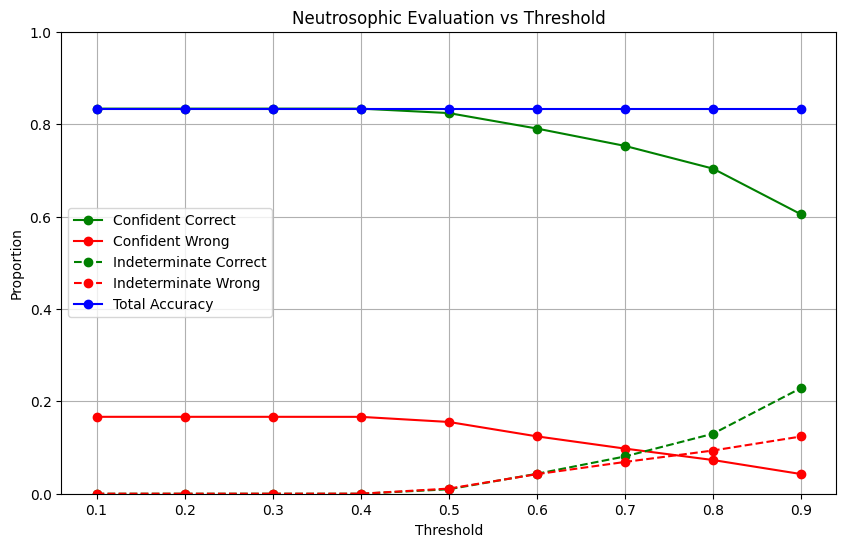

In [71]:
def threshold_sweep(model, X_test, y_test, thresholds=np.linspace(0.1, 0.9, 9)):
    results = []
    for th in thresholds:
        metrics = neutrosophic_evaluation(model, X_test, y_test, threshold=th)
        metrics["Threshold"] = th
        results.append(metrics)
    return results

thresholds = np.linspace(0.1, 0.9, 9)
results = threshold_sweep(model, X_test, y_test, thresholds)

conf_acc   = [r["Confident Accuracy"] for r in results]
conf_wrong = [r["Confident Wrong"] for r in results]
ind_correct= [r["Indeterminate Correct"] for r in results]
ind_wrong  = [r["Indeterminate Wrong"] for r in results]
total      = [r["Total Accuracy"] for r in results]

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, conf_acc,   marker='o', color='green',  label="Confident Correct")
plt.plot(thresholds, conf_wrong, marker='o', color='red',    label="Confident Wrong")
plt.plot(thresholds, ind_correct,marker='o', color='green', linestyle="--", label="Indeterminate Correct")
plt.plot(thresholds, ind_wrong,  marker='o', color='red', linestyle="--", label="Indeterminate Wrong")
plt.plot(thresholds, total,      marker='o', color='blue', label="Total Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Proportion")
plt.title("Neutrosophic Evaluation vs Threshold")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

##### Interpretation:

- Low confidence threshold → More coverage, but lots of confident wrongs.
- High threshold → Safer (fewer wrongs), but lots of indeterminates. Helps avoid making confident but incorrect predictions.

##### 12. Visualization


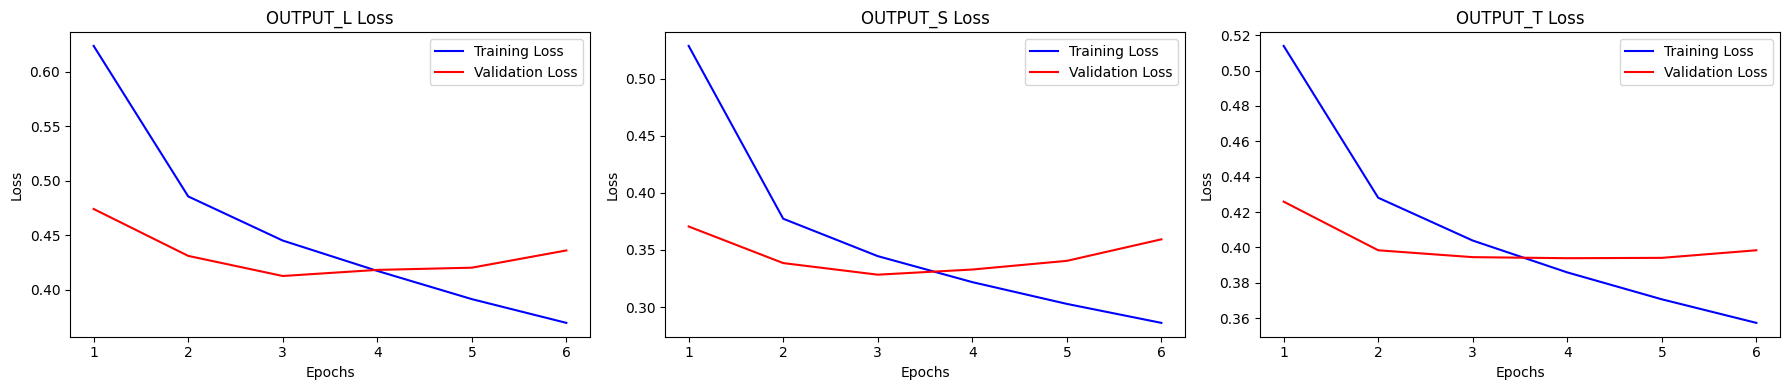

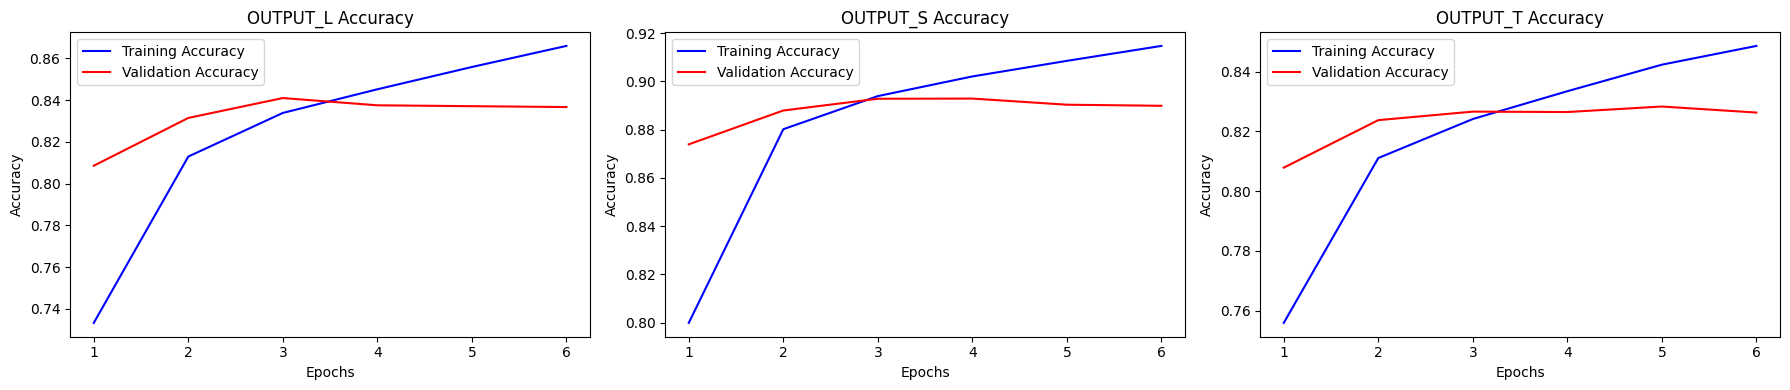

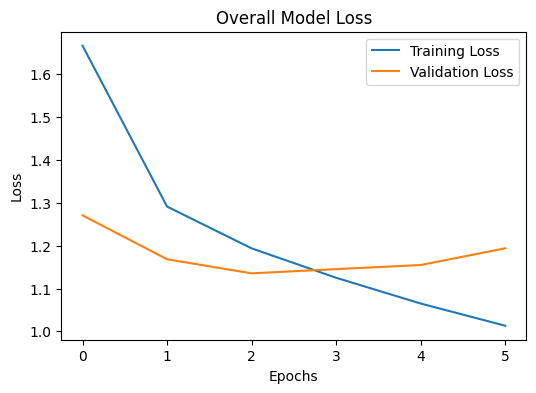

In [72]:
import matplotlib.pyplot as plt

def plot_output(history, outputs, metric="accuracy"):
    epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)

    # Accuracy plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_loss = history.history[f"{output}_loss"]
        val_loss = history.history[f"val_{output}_loss"]

        axes[i].plot(epochs, train_loss, "b", label="Training Loss")
        axes[i].plot(epochs, val_loss, "r", label="Validation Loss")
        axes[i].set_title(f"{output.upper()} Loss")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # Loss plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_metric = history.history[f"{output}_{metric}"]
        val_metric = history.history[f"val_{output}_{metric}"]

        axes[i].plot(epochs, train_metric, "b", label=f"Training {metric.title()}")
        axes[i].plot(epochs, val_metric, "r", label=f"Validation {metric.title()}")
        axes[i].set_title(f"{output.upper()} {metric.title()}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Overall Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

outputs = ["output_l", "output_s", "output_t"]
plot_output(history, outputs, metric="accuracy")
